In [43]:
import pandas as pd
import artm
import os
import re

In [44]:
COLLECTION = './Data/Component_Results/syntaxnet/lemmatized_collection/'
TOPMINE_OUTPUT = './Data/Component_Results/topmine/topmine.csv'

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

In [46]:
documents = []
filenames = []

for filename in os.listdir(COLLECTION):
    filenames.append(filename.split('.')[0])
    
    with open(COLLECTION + "/" + filename, "r") as f:
        doc = f.read()
        doc = re.sub(r'\.', '', doc)
        doc = re.sub(r' +', ' ', doc)
        documents.append(doc)

In [47]:
topmine_df = pd.read_csv(TOPMINE_OUTPUT, sep='\t')
collocs = list(topmine_df['ngramm'])
del topmine_df

# with open(COLLOCS, 'r') as f:
#     collocs = f.read().split('\n')

In [48]:
from tqdm import tqdm

In [ ]:
for document in tqdm(documents):
    words = document.split(' ')
    i = 0
    while True:
        flag = False
        for colloc in collocs:
            colloc_words = colloc.split(' ')
            candidate = words[i:i + len(colloc_words)]
            if candidate == colloc_words:
                i += len(colloc_words)
                flag = True
                break
        if not flag:
            new_document.append(words[i])
            i += 1
        if i >= len(words):
            break
    new_documents.append(new_document)

In [49]:
new_documents = []
for document in tqdm(documents):
    new_document = []
    words = document.split(' ')
    i = 0
    while True:
        flag = False
        for colloc in collocs:
            colloc_words = colloc.split(' ')
            candidate = words[i:i + len(colloc_words)]
            if candidate == colloc_words:
                new_document.append('_'.join(candidate))
                i += len(colloc_words)
                flag = True
                break
        if not flag:
            new_document.append(words[i])
            i += 1
        if i >= len(words):
            break
    new_documents.append(new_document)

100%|██████████| 198/198 [42:32<00:00, 12.89s/it]


In [53]:
docs = [' '.join(doc) for doc in new_documents]

In [54]:
cv = CountVectorizer(min_df=0, max_df=1.0)
X_test = cv.fit_transform(docs)
tokens = cv.get_feature_names()

In [55]:
import numpy as np

In [56]:
X_test.sum(axis=0).shape

(1, 27445)

In [57]:
# Убираем часто встречаемые
N = 30
counts = X_test.toarray().sum(axis=0)
inds = np.argpartition(-counts, np.arange(N))[:N]
# inds = np.array(inds.tolist()[0])[:N]

stopwords = []
for i in inds:
    stopwords.append(tokens[i])
    
# Убираем редко встречаемые
# inds = counts <= 2
# inds = inds.nonzero()[0]
# for i in inds:
#     stopwords.append(tokens[i])

In [58]:
len(stopwords)

30

In [59]:
cv = CountVectorizer(min_df=0, max_df=1.0, stop_words=stopwords)
X = cv.fit_transform(docs)

In [60]:
X.shape

(198, 27415)

In [61]:
vowpal_documents = []
for row, filename in zip(X, filenames):
    vowpal_doc = [filename, '|']
    for count, token in zip(row.toarray()[0], cv.get_feature_names()):
        if count != 0:
            vowpal_doc.append("{}:{}".format(token, count))
    vowpal_documents.append(' '.join(vowpal_doc))

In [62]:
VOWPAL_DOCS = 'vowpal_docs.txt'

In [63]:
with open(VOWPAL_DOCS, 'w') as f:
    f.write('\n'.join(vowpal_documents))

---

In [64]:
docword = [str(len(filenames)), str(X.shape[1]), '1']
for doc_id, row in enumerate(X):
    for word_id, count in enumerate(row.toarray()[0]):
        if count != 0:
            docword.append("{} {} {}".format(doc_id + 1, word_id + 1, count))

In [65]:
vocab = cv.get_feature_names()

In [66]:
DOCWORD = 'docword.wiki.txt'
VOCAB = 'vocab.wiki.txt'

In [67]:
with open(DOCWORD, 'w') as f:
    f.write('\n'.join(docword))

with open(VOCAB, 'w') as f:
    f.write('\n'.join(vocab))

---

In [68]:
TOPIC_NUM = 10

In [69]:
import artm

In [70]:
batch_vectorizer = artm.BatchVectorizer(data_path=VOWPAL_DOCS,
                                        data_format='vowpal_wabbit',
                                        collection_name='wiki',
                                        target_folder='artm_folder')

In [71]:
dictionary = batch_vectorizer.dictionary
topic_names = ['topic_{}'.format(i) for i in range(TOPIC_NUM)]

In [72]:
model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                       tau=-0.15),
                                     artm.DecorrelatorPhiRegularizer(name='Decorrelator',
                                                                     tau=0.1)]
                      )

In [73]:
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

In [74]:
model_artm.initialize(dictionary=dictionary)

In [75]:
%%time
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

CPU times: user 12.5 s, sys: 533 ms, total: 13.1 s
Wall time: 12.8 s


In [76]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['algorithm', 'problem', 'instance', 'then', 'we', 'learn']
topic_1: 
['between', 'machine_learn', 'data', 'model', 'distribution', 'may']
topic_2: 
['model', 'all', 'learn', 'when', 'set', 'these']
topic_3: 
['when', 'algorithm', 'there', 'data', 'their', 'than']
topic_4: 
['other', 'these', 'some', 'between', 'we', 'all']
topic_5: 
['probability', 'then', 'all', 'algorithm', 'data', 'some']
topic_6: 
['learn', 'model', 'some', 'machine_learn', 'but', 'these']
topic_7: 
['model', 'we', 'all', 'other', 'but', 'example']
topic_8: 
['then', 'we', 'some', 'model', 'all', 'there']
topic_9: 
['these', 'there', 'but', 'example', 'some', 'algorithm']


In [77]:
df_nwt = model_artm.get_phi(model_name=model_artm.model_nwt)

In [78]:
df_ptw = (df_nwt.T / df_nwt.sum(axis=1)).T

In [79]:
res_dict = dict()
no_collocs = []
for colloc in collocs:
    index = '_'.join(colloc.split(' '))
    if index in df_ptw.index:
        res_dict[colloc] = df_ptw.loc[index].values
    else:
        no_collocs.append(index)

In [80]:
len(no_collocs)

9567

In [81]:
from scipy.stats import entropy

In [82]:
def js(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
   # normalize
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2

In [83]:
def deg_func(p, gamma=2):
    return np.power(p, gamma).sum()

In [84]:
GAMMA = 2

ngrams = []
kl_divs = []
js_divs = []
degs = []

for ngram, distrib in res_dict.items():
    ngrams.append(ngram)
    kl_divs.append(entropy(distrib, np.ones(TOPIC_NUM) / TOPIC_NUM))
    js_divs.append(js(distrib, np.ones(TOPIC_NUM) / TOPIC_NUM))
    degs.append(deg_func(distrib, GAMMA))

In [85]:
df_topic = pd.DataFrame({'ngramm': ngrams, 'kl_div': kl_divs, 'js_div': js_divs, 'deg': degs})

In [86]:
df_topic.to_csv('./Data/Component_Results/bigartm/bigartm.csv')

---

In [87]:
import matplotlib.pyplot as plt

<BarContainer object of 10 artists>

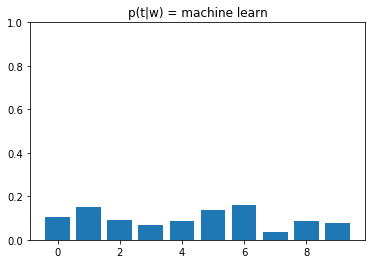

In [88]:
c = 'machine learn'
plt.ylim((0, 1))
plt.title('p(t|w) = {}'.format(c))
plt.bar(range(TOPIC_NUM), height=res_dict[c])